## Load Data

In [1]:
import pandas as pd
from feature_engine.wrappers import SklearnTransformerWrapper
from sklearn.preprocessing import StandardScaler

In [2]:
df = pd.read_csv("../data/raw/marketing_campaign.csv", sep="\t")

## Process data

In [3]:
# Drop na
df = df.dropna()

In [4]:
# Get age
df = df.assign(age=df["Year_Birth"].apply(lambda row: 2021 - row))

In [5]:
# Get total children
df = df.assign(total_children=df["Kidhome"] + df["Teenhome"])

In [6]:
# Get total purchases
purchases_columns = df.filter(like="Purchases", axis=1).columns
df = df.assign(total_purchases=df[purchases_columns].sum(axis=1))

In [7]:
# Get enrollment years
df["Dt_Customer"] = pd.to_datetime(df["Dt_Customer"])
df = df.assign(enrollment_years=2022 - df["Dt_Customer"].dt.year)

In [8]:
# Get family size
size_map = {
    "Married": 2,
    "Together": 2,
    "Absurd": 1,
    "Widow": 1,
    "YOLO": 1,
    "Divorced": 1,
    "Single": 1,
    "Alone": 1,
}

df = df.assign(family_size=df["Marital_Status"].map(size_map) + df["total_children"])

In [9]:
# Drop features

drop_columns = [
    "ID",
    "Year_Birth",
    "Dt_Customer",
    "Marital_Status",
    "Z_CostContact",
    "Z_Revenue",
    "Kidhome",
    "Teenhome",
    "total_children",
    "Education",
    "NumWebPurchases",
    "NumCatalogPurchases",
    "NumStorePurchases",
    "NumDealsPurchases",
    "MntWines",
    "MntFruits",
    "MntMeatProducts",
    "MntFishProducts",
    "MntSweetProducts",
    "MntGoldProds",
]

df = df.drop(drop_columns, axis=1).reset_index(drop=True)

In [10]:
# Drop outliers
column_threshold = {"age": 90, "Income": 600000}
for col, threshold in column_threshold.items():
    df = df[df[col] < threshold]

In [11]:
# Scale features
scaler = SklearnTransformerWrapper(transformer=StandardScaler())
df = scaler.fit_transform(df)

In [12]:
df

,Income,Recency,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,age,total_purchases,enrollment_years,family_size
0,0.287105,0.310353,0.692181,-0.282048,-0.282981,-0.280175,-0.261914,-0.117256,-0.09552,2.375425,1.018352,1.317945,1.499086,-1.758359
1,-0.260882,-0.380813,-0.132545,-0.282048,-0.282981,-0.280175,-0.261914,-0.117256,-0.09552,-0.420977,1.274785,-1.159273,-1.417341,0.449070
2,0.913196,-0.795514,-0.544908,-0.282048,-0.282981,-0.280175,-0.261914,-0.117256,-0.09552,-0.420977,0.334530,0.796425,0.040872,-0.654644
3,-1.176114,-0.795514,0.279818,-0.282048,-0.282981,-0.280175,-0.261914,-0.117256,-0.09552,-0.420977,-1.289547,-0.898513,-1.417341,0.449070
4,0.294307,1.554453,-0.132545,-0.282048,-0.282981,-0.280175,-0.261914,-0.117256,-0.09552,-0.420977,-1.033114,0.535666,-1.417341,0.449070
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2211,0.430444,-0.104347,-0.132545,-0.282048,-0.282981,-0.280175,-0.261914,-0.117256,-0.09552,-0.420977,0.163575,0.405286,0.040872,0.449070
2212,0.560123,0.241237,0.692181,-0.282048,-0.282981,-0.280175,3.818045,-0.117256,-0.09552,-0.420977,1.958607,0.926805,-1.417341,2.656499
2213,0.233347,1.450778,0.279818,-0.282048,3.533809,-0.280175,-0.261914,-0.117256,-0.09552,-0.420977,-1.033114,0.535666,-1.417341,-1.758359
2214,0.803172,-1.417564,-0.957271,-0.282048,-0.282981,-0.280175,-0.261914,-0.117256,-0.09552,-0.420977,1.103830,1.057185,-1.417341,0.449070


## Segmentation

In [13]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer

In [14]:
# Reduce dimension
pca = PCA(n_components=3)
pca_df = pd.DataFrame(pca.fit_transform(df), columns=["col1", "col2", "col3"])

In [15]:
# A 3D Projection Of Data In The Reduced Dimensionality Space
projection = {"x": pca_df["col1"], "y": pca_df["col2"], "z": pca_df["col3"]}

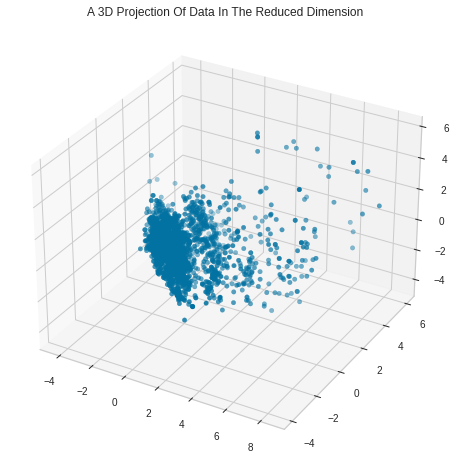

In [16]:
# Create 3D plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(
    projection["x"],
    projection["y"],
    projection["z"],
    cmap="Accent",
    marker="o",
)
ax.set_title("A 3D Projection Of Data In The Reduced Dimension")
plt.show()

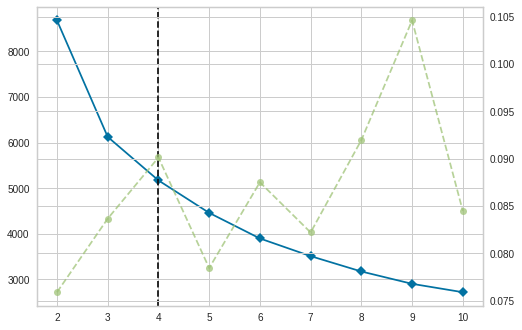

In [17]:
# Get best k cluster
elbow = KElbowVisualizer(KMeans(), k=10)
elbow.fit(pca_df)

k_best = elbow.elbow_value_

In [18]:
# Get clusters
model = AgglomerativeClustering(n_clusters=k_best)
preds = model.fit_predict(pca_df)

In [19]:
# Insert clusters to df
df = df.assign(clusters=preds)

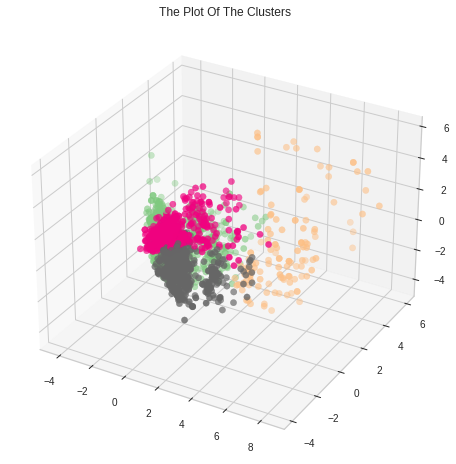

In [20]:
# Plot clusters
pca_df["clusters"] = preds

plt.figure(figsize=(10, 8))
ax = plt.subplot(111, projection="3d")
ax.scatter(
    projection["x"],
    projection["y"],
    projection["z"],
    s=40,
    c=pca_df["clusters"],
    marker="o",
    cmap="Accent",
)
ax.set_title("The Plot Of The Clusters")
plt.show()